<a href="https://colab.research.google.com/github/egorkorolkov/DLS_hw/blob/main/NLP/DLS_GPT_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделями трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего.

In [4]:
emotion_dataset = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Посмотри, из чего состоит `emotion_dataset`:

In [5]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
emotion_dataset["train"]["text"][1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

In [8]:
emotion_dataset["train"]["label"][1]

0

In [9]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [10]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [11]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [12]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [15]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0],
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [16]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [17]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}

    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]

        tokenizer_output = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'].squeeze(0),
            "mask": tokenizer_output['attention_mask'].squeeze(0),
            "target": target
        }

    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [18]:
train_dataset = TweetDataset('train', emotion_dataset, tokenizer)
valid_dataset = TweetDataset('validation', emotion_dataset, tokenizer) # validation
test_dataset = TweetDataset('test', emotion_dataset, tokenizer)

In [19]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [20]:
device

'cuda'

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [21]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [34]:
model_0

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=8, bias=False)
)

Подготовь оптимайзер и критерий:

In [22]:
LR = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
SCHEDULER_LAMBDA_PARAM = 0.96
optimizer = torch.optim.AdamW(model_0.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
lambda_scheduler = lambda x: SCHEDULER_LAMBDA_PARAM ** x
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [24]:
from tqdm.notebook import tqdm


def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss_sum = 0
    for batch in tqdm(dataloader, desc="training", leave=False):
        features = batch['input_ids'].to(device)
        attention_mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=features, attention_mask=attention_mask)
        loss = criterion(outputs.logits, targets)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
    return train_loss_sum / len(dataloader)

@torch.no_grad()
def validate(model, dataloader, criterion, test=False, print_results=False):
    model.eval()
    loss_sum = 0
    true_preds = 0
    total_examples = 0
    desc = "testing" if test else "validation"
    for batch in tqdm(dataloader, desc=desc, leave=False):
        features = batch['input_ids'].to(device)
        attention_mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids=features, attention_mask=attention_mask)
        loss = criterion(outputs.logits, targets)

        loss_sum += loss.item()
        true_preds += (outputs.logits.argmax(-1) == targets).sum().item()
        total_examples += features.shape[0]
    res = dict(
        loss=loss_sum / len(dataloader),
        accuracy=true_preds / total_examples,
        mode = "Test" if test else "Valid"
        )
    if print_results:
        print("{mode} Loss: {loss} | {mode} Accuracy: {accuracy}".format(**res))
    return res

def train_validate_model(
        model, num_epochs, train_loader, criterion, optimizer,
        valid_loader=None, lr_scheduler=None, start_epoch=1):
    for e in tqdm(range(start_epoch, num_epochs + 1), desc="epoch"):
        train_loss = train(model, train_loader, criterion, optimizer)
        report_msg = f"Epoch: {e} | Train Loss: {train_loss}"
        if valid_loader is not None:
            valid_res = validate(model, valid_loader, criterion, print_results=False)
            report_msg += " | Valid Loss: {loss} | Valid Accuracy: {accuracy}".format(**valid_res)
        if lr_scheduler is not None:
            lr_scheduler.step()
        print(report_msg)

In [25]:
num_epochs=10
train_validate_model(model_0, num_epochs, train_loader=train_loader, criterion=criterion,
                     optimizer=optimizer, valid_loader=valid_loader, lr_scheduler=scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 1.4607586488127708 | Valid Accuracy: 0.4475
Epoch: 1 | Train Loss: 1.5679589300155639 | Valid Loss: 1.4607586488127708 | Valid Accuracy: 0.4475


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 1.0790679473429918 | Valid Accuracy: 0.607
Epoch: 2 | Train Loss: 1.2633476135730743 | Valid Loss: 1.0790679473429918 | Valid Accuracy: 0.607


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.7920111082494259 | Valid Accuracy: 0.722
Epoch: 3 | Train Loss: 0.8628310482501984 | Valid Loss: 0.7920111082494259 | Valid Accuracy: 0.722


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.7024452136829495 | Valid Accuracy: 0.761
Epoch: 4 | Train Loss: 0.6141950099468231 | Valid Loss: 0.7024452136829495 | Valid Accuracy: 0.761


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.6485401019454002 | Valid Accuracy: 0.792
Epoch: 5 | Train Loss: 0.42572956043481824 | Valid Loss: 0.6485401019454002 | Valid Accuracy: 0.792


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.5521018747240305 | Valid Accuracy: 0.823
Epoch: 6 | Train Loss: 0.31206841045618056 | Valid Loss: 0.5521018747240305 | Valid Accuracy: 0.823


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.516832628287375 | Valid Accuracy: 0.842
Epoch: 7 | Train Loss: 0.23040323010087013 | Valid Loss: 0.516832628287375 | Valid Accuracy: 0.842


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.4905723547562957 | Valid Accuracy: 0.8475
Epoch: 8 | Train Loss: 0.17732027603685857 | Valid Loss: 0.4905723547562957 | Valid Accuracy: 0.8475


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.48490511579439044 | Valid Accuracy: 0.8595
Epoch: 9 | Train Loss: 0.14523553697764874 | Valid Loss: 0.48490511579439044 | Valid Accuracy: 0.8595


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.4744619084522128 | Valid Accuracy: 0.87
Epoch: 10 | Train Loss: 0.11748253405094147 | Valid Loss: 0.4744619084522128 | Valid Accuracy: 0.87


In [30]:
result = validate(model_0, test_loader, criterion, test=True, print_results=True)

testing:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 0.40966678922995925 | Test Accuracy: 0.872


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [26]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))

    return np.array(attn)

In [27]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [28]:
text = emotion_dataset["test"]["text"][15]# Выбери текст из датасета
tokens = tokenizer.tokenize(text)

<ipython-input-27-0d31a6ec8e7d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
<ipython-input-27-0d31a6ec8e7d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


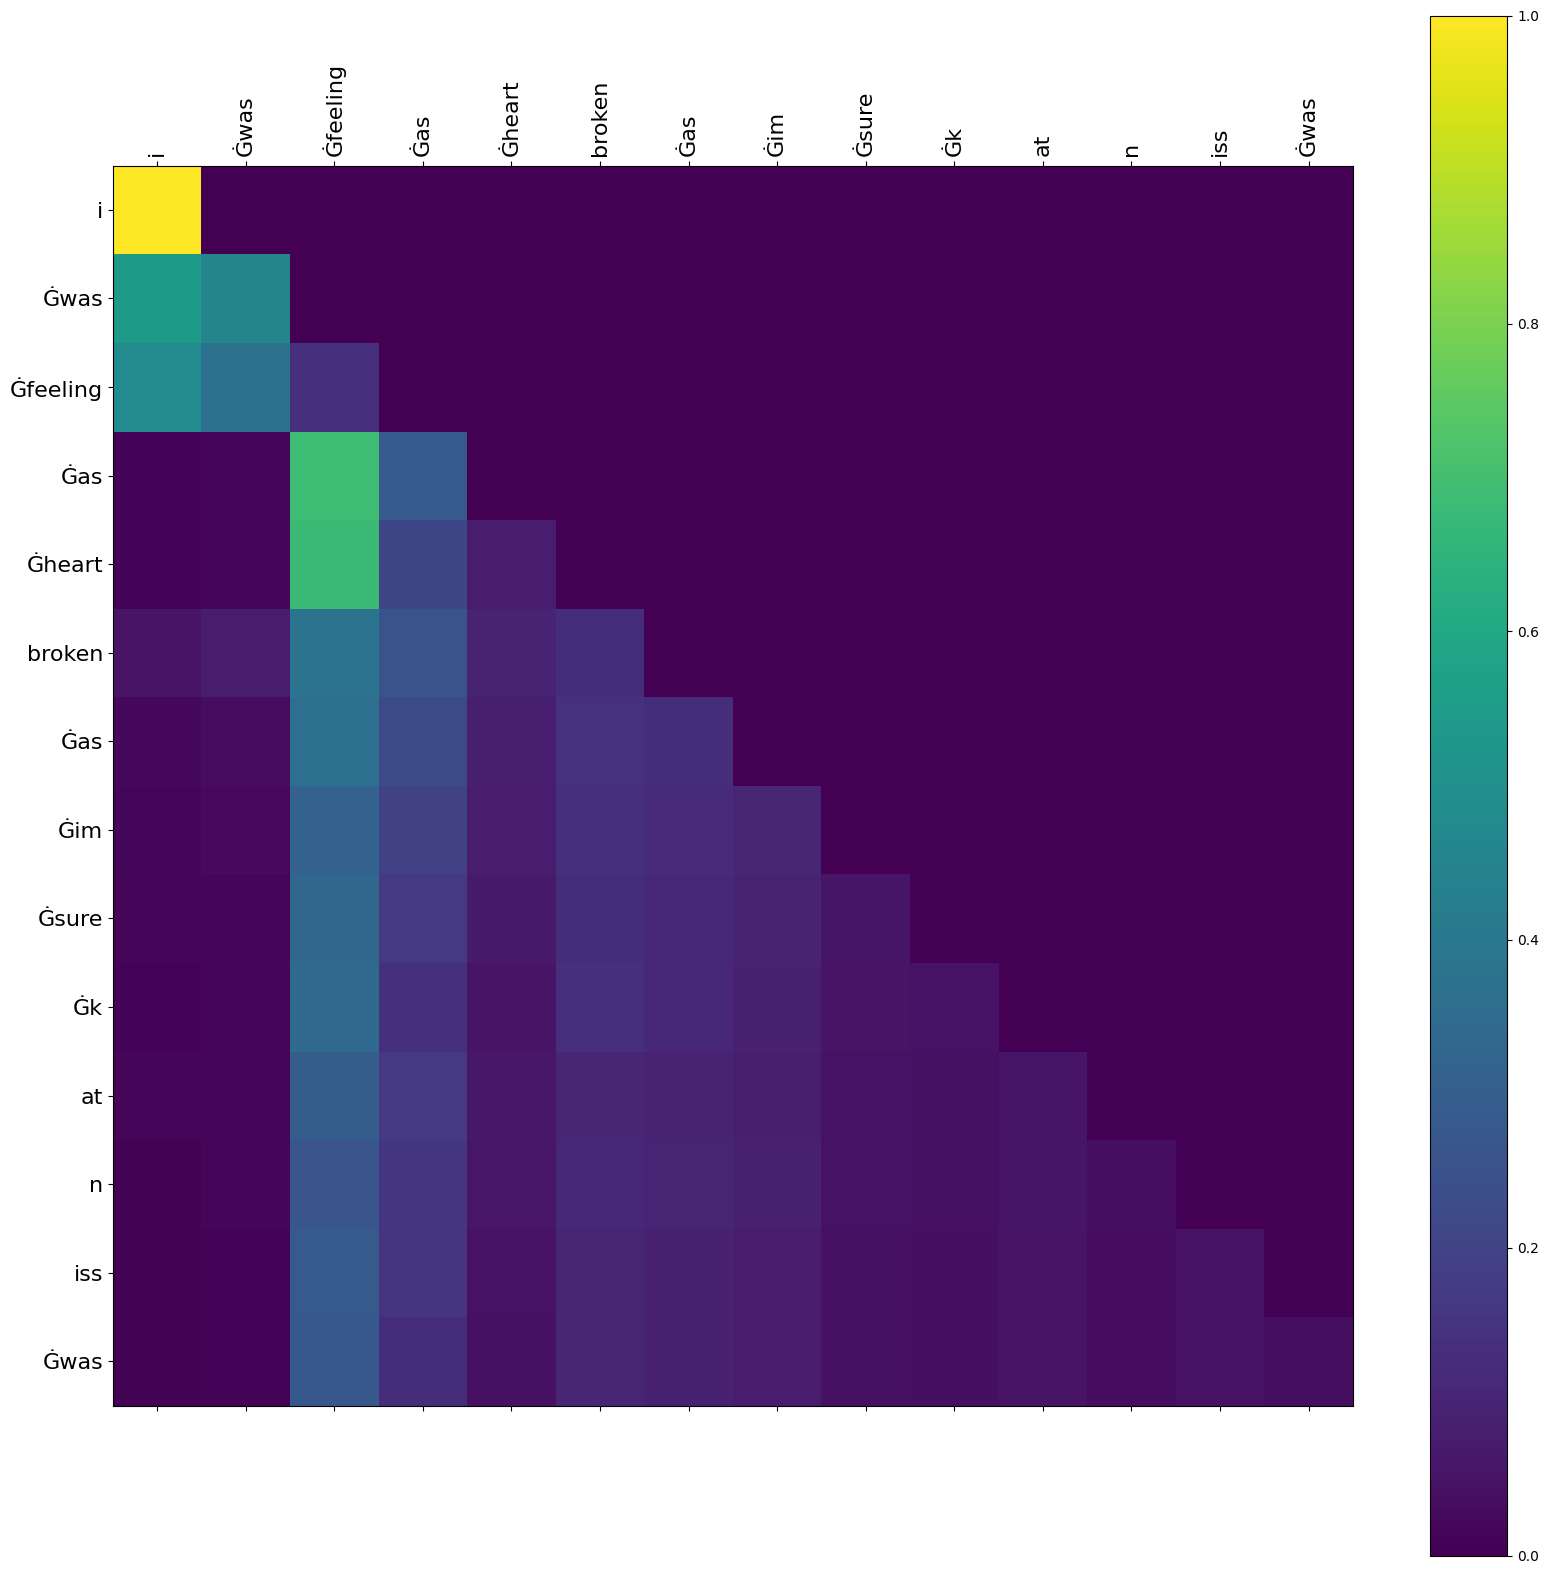

In [29]:
attn = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attn[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [32]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2",
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
LR = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
SCHEDULER_LAMBDA_PARAM = 0.96
optimizer = torch.optim.AdamW(model_1.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
lambda_scheduler = lambda x: SCHEDULER_LAMBDA_PARAM ** x
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [36]:
num_epochs=10
train_validate_model(model_1, num_epochs, train_loader=train_loader, criterion=criterion,
                     optimizer=optimizer, valid_loader=valid_loader, lr_scheduler=scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 1.091062417253852 | Valid Accuracy: 0.595
Epoch: 1 | Train Loss: 1.6946662201881408 | Valid Loss: 1.091062417253852 | Valid Accuracy: 0.595


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.4208154436200857 | Valid Accuracy: 0.8585
Epoch: 2 | Train Loss: 0.8122524250745773 | Valid Loss: 0.4208154436200857 | Valid Accuracy: 0.8585


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.26018549781292677 | Valid Accuracy: 0.9065
Epoch: 3 | Train Loss: 0.41660342425107955 | Valid Loss: 0.26018549781292677 | Valid Accuracy: 0.9065


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.2065847790800035 | Valid Accuracy: 0.923
Epoch: 4 | Train Loss: 0.2871562889814377 | Valid Loss: 0.2065847790800035 | Valid Accuracy: 0.923


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.18973795732017606 | Valid Accuracy: 0.923
Epoch: 5 | Train Loss: 0.22445379304885865 | Valid Loss: 0.18973795732017606 | Valid Accuracy: 0.923


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.17929091746918857 | Valid Accuracy: 0.9265
Epoch: 6 | Train Loss: 0.19373630632460118 | Valid Loss: 0.17929091746918857 | Valid Accuracy: 0.9265


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.17340061301365495 | Valid Accuracy: 0.928
Epoch: 7 | Train Loss: 0.16959947857260704 | Valid Loss: 0.17340061301365495 | Valid Accuracy: 0.928


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.15960489364806563 | Valid Accuracy: 0.927
Epoch: 8 | Train Loss: 0.1565508449971676 | Valid Loss: 0.15960489364806563 | Valid Accuracy: 0.927


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.1538245528936386 | Valid Accuracy: 0.9335
Epoch: 9 | Train Loss: 0.1431962932944298 | Valid Loss: 0.1538245528936386 | Valid Accuracy: 0.9335


training:   0%|          | 0/250 [00:00<?, ?it/s]

validation:   0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss: 0.14821839367505163 | Valid Accuracy: 0.9315
Epoch: 10 | Train Loss: 0.13295030571520328 | Valid Loss: 0.14821839367505163 | Valid Accuracy: 0.9315


In [37]:
result = validate(model_1, test_loader, criterion, test=True, print_results=True)

testing:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 0.16800394421443343 | Test Accuracy: 0.9265


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

<ipython-input-27-0d31a6ec8e7d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
<ipython-input-27-0d31a6ec8e7d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


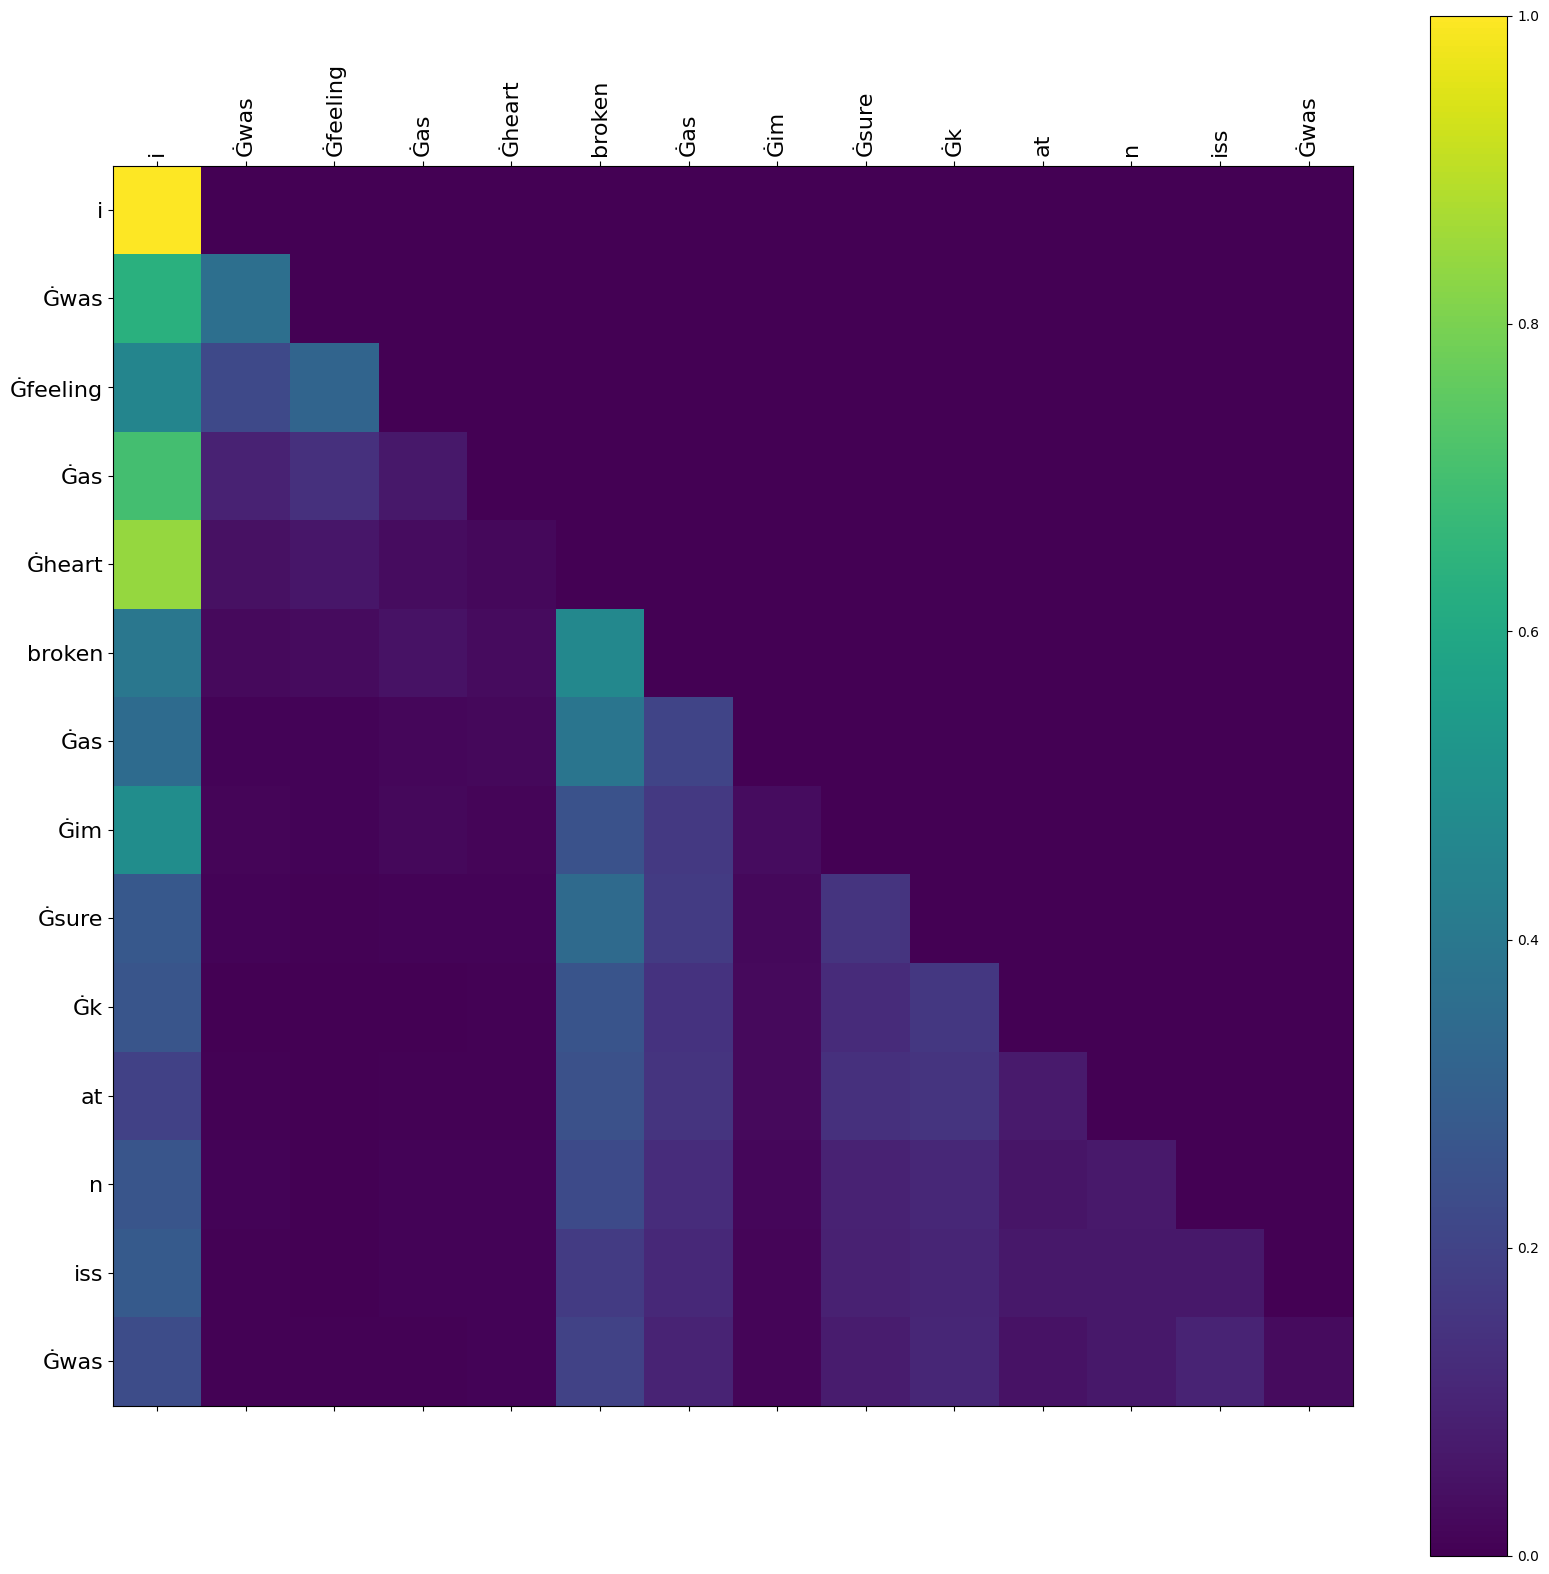

In [38]:
attn = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attn[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше?

— Лучше оказался подход с дообучением модели, заметно выросло качество.
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?
